<h1 align=center><font size = 8>Situación Covid-19 en Galicia</font></h1>

El propósito de este notebook es capturar de la <a href="https://coronavirus.sergas.gal/datos/#/gl-ES/undefined">web del Sergas</a> los datos actualizados de la situación de Galicia frente al Covid-19, y posteriormente realizar algunos análisis básicos, guardando los resultados en directorios.

Para los cálculos basados en el número de habitantes se emplea un fichero csv obteniendo mediante otro notebook, llamado _Población Areas_ y también disponible en el repositorio de GitHub. Se debe de tener en cuenta que en este análisis se trabaja con áreas sanitarias y no con ayuntamientos. Pese a que todos los nombres de las áreas sanitarias coinciden también con nombres de ayuntamientos, en ellas se encuentran englobadas otras comarcas y ayuntamientos limítrofes y próximas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta
import sys
import requests
import datetime
import os

In [2]:
class covid19galicia:
    
    def __init__(self):
        global path
        global datefile
        global dict_areas
        global pop
        
        path = 'https://coronavirus.sergas.gal/infodatos/'
        dict_areas={'A.S. A CORUÑA E CEE':'A Coruña',
                    'A.S. FERROL':'Ferrol',
                    'A.S. LUGO, A MARIÑA E MONFORTE':'Lugo',
                    'A.S. OURENSE, VERÍN E O BARCO':'Ourense',
                    'A.S. PONTEVEDRA E O SALNÉS':'Pontevedra',
                    'A.S. SANTIAGO E BARBANZA':'Santiago',
                    'A.S. VIGO':'Vigo'
                   }
        file = '_COVID19_Web_CifrasTotais.csv'
        #Obtiene el día 'datefile' más reciente en los ficheros
        for i in range(0,10):
            datefile = (date.today() - timedelta(days=i)).strftime("%Y-%m-%d")
            filepath = path+datefile+file
            response = requests.head(filepath)
            if response.status_code == requests.codes.ok:
                print('Ultima actualización: '+datefile)
                break;
            elif i == 9:
                print('Algo ha ido mal. La web lleva muchos días sin actualizarse o ha cambiado su estructura')
                
        pop = pd.read_csv('poblacion.csv')
        self.__makeDir()
         
    
    def __makeDir(self):
        savepath = datefile
        try:
            os.mkdir(savepath)
        except OSError:
            print('No se ha podido crear el directorio')
        os.chdir(savepath)
        
    def getActivosCuradosFallecidos(self):
        file = '_COVID19_Web_ActivosCuradosFallecidos.csv'
        df = pd.read_csv(path+datefile+file, decimal=',', thousands='.')
        df['Area_Sanitaria'] = df['Area_Sanitaria'].replace(dict_areas)
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        
        return df
    
    
    def getCifrasTotais(self):
        file = '_COVID19_Web_CifrasTotais.csv'
        df = pd.read_csv(path+datefile+file, decimal=',', thousands='.')
        df['Fecha'] = [(d[0]) for d in df['Fecha'].str.split(' ')]
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        df['Area_Sanitaria'] = df['Area_Sanitaria'].replace(dict_areas)
        df = df[df['Area_Sanitaria'] != 'GALICIA']
        
        return df
    
    
    def getFallecidos(self):
        file = '_COVID19_Web_Fallecidos.csv'
        df = pd.read_csv(path+datefile+file, decimal=',', thousands='.')
        df['Area_Sanitaria'] = df['Area_Sanitaria'].replace(dict_areas)
        
        return df
    
    def getInfectados(self):
        file = '_COVID19_Web_InfectadosPorFecha.csv'
        df = pd.read_csv(path+datefile+file, decimal=',', thousands='.')
        df['Area_Sanitaria'] = df['Area_Sanitaria'].replace(dict_areas)
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        
        return df
    
    
    def getOcupacionCamas(self):
        file = '_COVID19_Web_OcupacionCamasHospital.csv'
        df = pd.read_csv(path+datefile+file, decimal=',', thousands='.')
        df['Fecha'] = [(d[0]) for d in df['Fecha'].str.split(' ')]
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        df['Area_Sanitaria'] = df['Area_Sanitaria'].replace(dict_areas)
        df = df[df['Area_Sanitaria'] != 'GALICIA']
        
        return df
    
    
    def getInfeccionesPorFecha(self):
        file = '_COVID19_Web_PorcentajeInfeccionesPorFecha.csv'
        df = pd.read_csv(path+datefile+file, decimal=',', thousands='.')
        df['Area_Sanitaria'] = df['Area_Sanitaria'].replace(dict_areas)
        df['Fecha'] = pd.to_datetime(df['Fecha'])
        df['Porcentaje_Infecciones'] = [float(p[0].replace(',','.')) for p in df['Porcentaje_Infecciones'].str.split('%')]
        df.rename(columns={'Area_Sanitaria':'Area', 'Casos_Abiertos':'Positivos','Pruebas_PCR_Realizadas':'PCR',
                           'Porcentaje_Infecciones':'%Infecciones'}, inplace=True)
        
        return df
    
    
    def getInfectadosGenero(self):
        file = '_COVID19_Web_PorcentajeInfectadosPorGenero.csv'
        df = pd.read_csv(path+datefile+file, decimal=',', thousands='.')
        df['Area_Sanitaria'] = df['Area_Sanitaria'].replace(dict_areas)
        
        return df
          
    
    def plotCasosActivos(self, casos_activos, cienmil):
        values = []
        title, xlabel, savename = "", "", ""
        offset = 0
        if cienmil:
            df = pd.merge(how='inner', left=casos_activos, right=pop, left_on='Area_Sanitaria', right_on='Area sanitaria')
            df['100.000h'] = round((df['Pacientes_Sin_Alta']*100000)/df['Habitantes'])
            df = df[['Area_Sanitaria','100.000h']].sort_values('100.000h', ascending=True)
            title = 'Casos activos / 100.000 habitantes por área sanitaria'
            xlabel = 'Casos activos/100.000h'
            values = list(df['100.000h'])
            savename = '_casos_activos_100000h.png'
            offset = 5
        else:
            df = casos_activos[['Area_Sanitaria','Pacientes_Sin_Alta']].sort_values('Pacientes_Sin_Alta')
            title = 'Casos activos - Total por área sanitaria'
            xlabel = 'Casos activos'
            values = list(df['Pacientes_Sin_Alta'])
            savename = '_casos_activos_total.png'
            offset = 20
            
        df.plot(kind='barh', x='Area_Sanitaria', legend=False, figsize=(14,8), color='darkcyan', alpha=0.5)
        plt.title(title)
        plt.ylabel('Área sanitaria')
        plt.xlabel(xlabel)
        
        for i,val in enumerate(values):
            label = format(int(val), ',').replace(',','.')
            plt.annotate(label, xy=(val-offset,i), color='white', fontweight='semibold', ha='right', va='center')
        plt.savefig(datefile+savename)    
        plt.show()
        
        
    def plotPorcentajeAreas(self, casos_activos):
        colors=['lightsteelblue','lavender','honeydew','paleturquoise','moccasin','thistle','mistyrose']
        df = casos_activos[['Area_Sanitaria','Pacientes_Sin_Alta']].sort_values('Pacientes_Sin_Alta')
        df[['Pacientes_Sin_Alta']].plot(kind='pie',labels=df['Area_Sanitaria'],subplots=True,
                                        figsize=(10,10),shadow=True,startangle=90,pctdistance=0.85,
                                        autopct='%1.1f%%',colors=colors,legend=False)

        plt.title('Casos activos - Porcentaje por área sanitaria')
        plt.ylabel(None)
        plt.savefig(datefile+'_casos_activos_porcentaje.png') 
        plt.show()
        
        
    def plotAcumulados(self, daily_data, kind, days):
        areas = ['A Coruña', 'Ferrol', 'Lugo', 'Ourense', 'Pontevedra', 'Santiago', 'Vigo', 'GALICIA']
        colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'magenta', 'olive']

        if kind == 'Casos':
            searched = 'Positivos'
            ylabel = kind
            save_title = '_positivos'
        elif kind == 'PCR':
            searched = '%Infecciones'
            ylabel = '% PCR Positivas'
            save_title = '_PCR_positivas'
        else:
            print("Sólo se permiten 'casos' y 'pcr' como tipos de gráfica")
            return
        
        fig, axes = plt.subplots(4,2)
        fig.set_size_inches(18,32)
        fig.suptitle(ylabel+' '+str(days)+' días por área sanitaria - Evolución', fontsize=22, y=0.92)

        for i,ax in enumerate(axes.flatten()):
            df = daily_data[['Fecha','Positivos','PCR','%Infecciones']][daily_data['Area']==areas[i]]
            yvalues = list(df[searched])
            
            if days > 0:
                if kind == 'Casos':
                    acu = list(df[searched].cumsum())
                    for j in range(days,len(acu)+1):
                        acu[j-1] = df[searched].iloc[j-days:j].sum()
                elif kind == 'PCR':
                    acu = list(100*(df['Positivos'].cumsum() / df['PCR'].cumsum()))
                    for j in range(days,len(acu)+1):
                        acu[j-1] = round(100*(df['Positivos'].iloc[j-days:j].sum() / df['PCR'].iloc[j-days:j].sum()), 2)
                yvalues = acu
                variation = round((acu[-1]/acu[-2]-1)*100, 1)
                text_print = 'Último valor = {0} ({1:+}%)'.format(acu[-1],variation)
                days_title = '_'+str(days)+'dias'
            else:
                text_print = 'Último valor = ' + str(yvalues[-1])
                days_title = '_diario'
                                                     
            ax.plot(df['Fecha'],yvalues,color=colors[i],alpha=0.6)
            ax.text(datetime.datetime.strptime('2020-05-01','%Y-%m-%d'),
                    max(yvalues)*0.7,
                    text_print, color='black', size=12)
            if kind=='PCR':
                #5% recomendado por OMS
                ax.plot(df['Fecha'],np.full(len(df),5),color='red')
                ax.text(datetime.datetime.strptime('2020-05-01','%Y-%m-%d'), 5.2, 'Recomendado OMS', color='black', size=10)
            ax.grid(alpha=0.3)
            ax.set_title(areas[i], fontsize=14)
            ax.set_xlabel(None)
            ax.set_ylabel(ylabel)    

        plt.savefig(datefile+save_title+days_title+'.png', dpi=90)
        plt.show()
        
    def plotOcupacionCamas(self, camas):
        df = camas.groupby(['Area_Sanitaria']).sum()
        df['Ingresados'] = df['Camas_Ocupadas_HOS'] + df['Camas_Ocupadas_UC']
        df.sort_values('Ingresados', ascending=True, axis=0, inplace=True)
        df.drop(columns=['Ingresados'], axis=1, inplace=True)

        df.plot(kind='barh',stacked=True,figsize=(14,8),alpha=0.5,color=['darkcyan','coral'])
        val_prev = []
        for i,val in enumerate(df['Camas_Ocupadas_HOS']):
            label = format(int(val), ',').replace(',','.')
            plt.annotate(label,xy=(val-1,i),color='white',fontweight='semibold',ha='right',va='center')
            val_prev.append(val)
        for i,val in enumerate(df['Camas_Ocupadas_UC']):
            if not val==0:
                label = format(int(val), ',').replace(',','.')
                plt.annotate(label,xy=(val_prev[i]+val-0.5,i),color='black',fontweight='semibold',ha='right',va='center')

        plt.title('Ocupación actual de camas en Galicia')        
        plt.xlabel('Camas')
        plt.ylabel('Area Sanitaria')
        plt.legend(['Camas ocupadas planta','Camas UCI'])
        plt.savefig(datefile+'_camas_ocupadas_por_area.png')    
        plt.show()

# 1. Importación de datos

Creamos la clase que maneja los datos de la web del Sergas e importamos solamente aquellos que son necesarios para las futuras gráficas.

In [3]:
galicia = covid19galicia()
casos_activos = galicia.getCifrasTotais()
infectados_fecha = galicia.getInfeccionesPorFecha()
camas = galicia.getOcupacionCamas()

Ultima actualización: 2020-11-01


Podemos visualizar los datos del último día:

In [19]:
total = galicia.getCifrasTotais()
print('En las últimas 24h hubo {} casos en Galicia'.format(total['Casos_Confirmados_PCR_Ultimas24h'].sum()))
total

En las últimas 24h hubo 597 casos en Galicia


,Fecha,Area_Sanitaria,Casos_Totais,Casos_Confirmados_PCR_Ultimas24h,Pacientes_Sin_Alta,Pacientes_Con_Alta,Camas_Ocupadas_HOS,Camas_Ocupadas_UCI,Probas_Realizadas_PCR,Probas_Realizadas_Non_PCR,Exitus
0,2020-11-01,A Coruña,8962,104,1575,7165,111,14,161224,67391,224
1,2020-11-01,Ferrol,2219,48,954,1223,36,7,47722,26394,40
2,2020-11-01,Lugo,4468,39,983,3388,33,5,80754,68168,98
3,2020-11-01,Ourense,6522,87,1299,4983,80,16,95408,62756,240
4,2020-11-01,Pontevedra,3599,109,1049,2519,61,6,66453,41037,31
5,2020-11-01,Santiago,6027,55,1360,4525,65,13,112796,81915,142
6,2020-11-01,Vigo,6169,155,2072,3949,60,16,135996,53430,148


# 2. Análisis

## 2.1. Casos activos - Total por área sanitaria

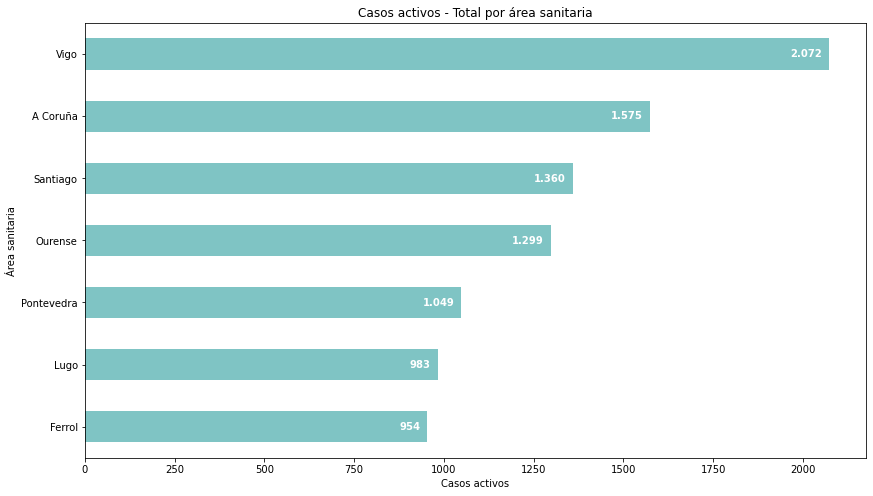

In [4]:
galicia.plotCasosActivos(casos_activos, cienmil=False)

## 2.2. Casos activos - Porcentaje por área sanitaria

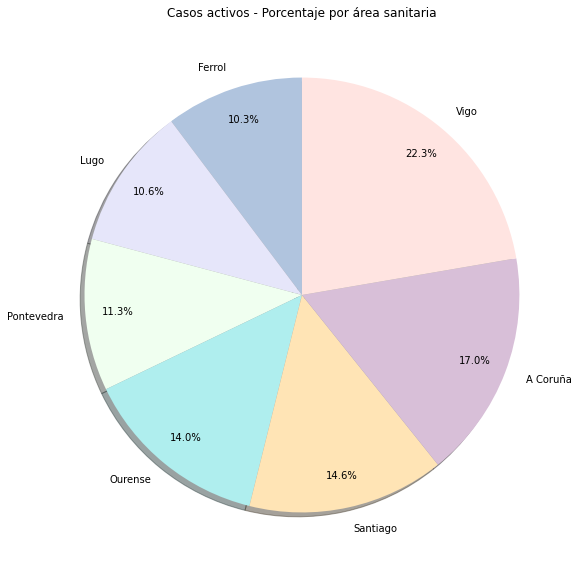

In [5]:
galicia.plotPorcentajeAreas(casos_activos)

## 2.3. Casos activos por 100.000 habitantes

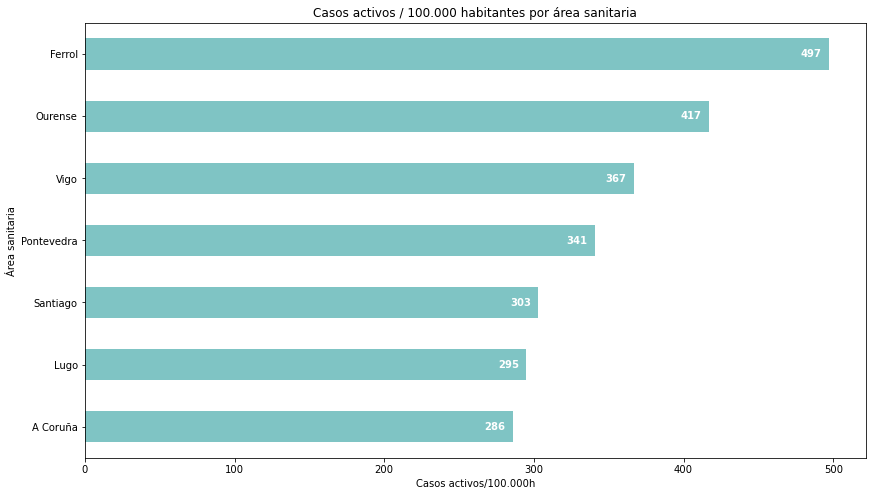

In [6]:
galicia.plotCasosActivos(casos_activos, cienmil=True)

## 2.4. Positivos

### 2.4.1. Evolución de positivos diarios

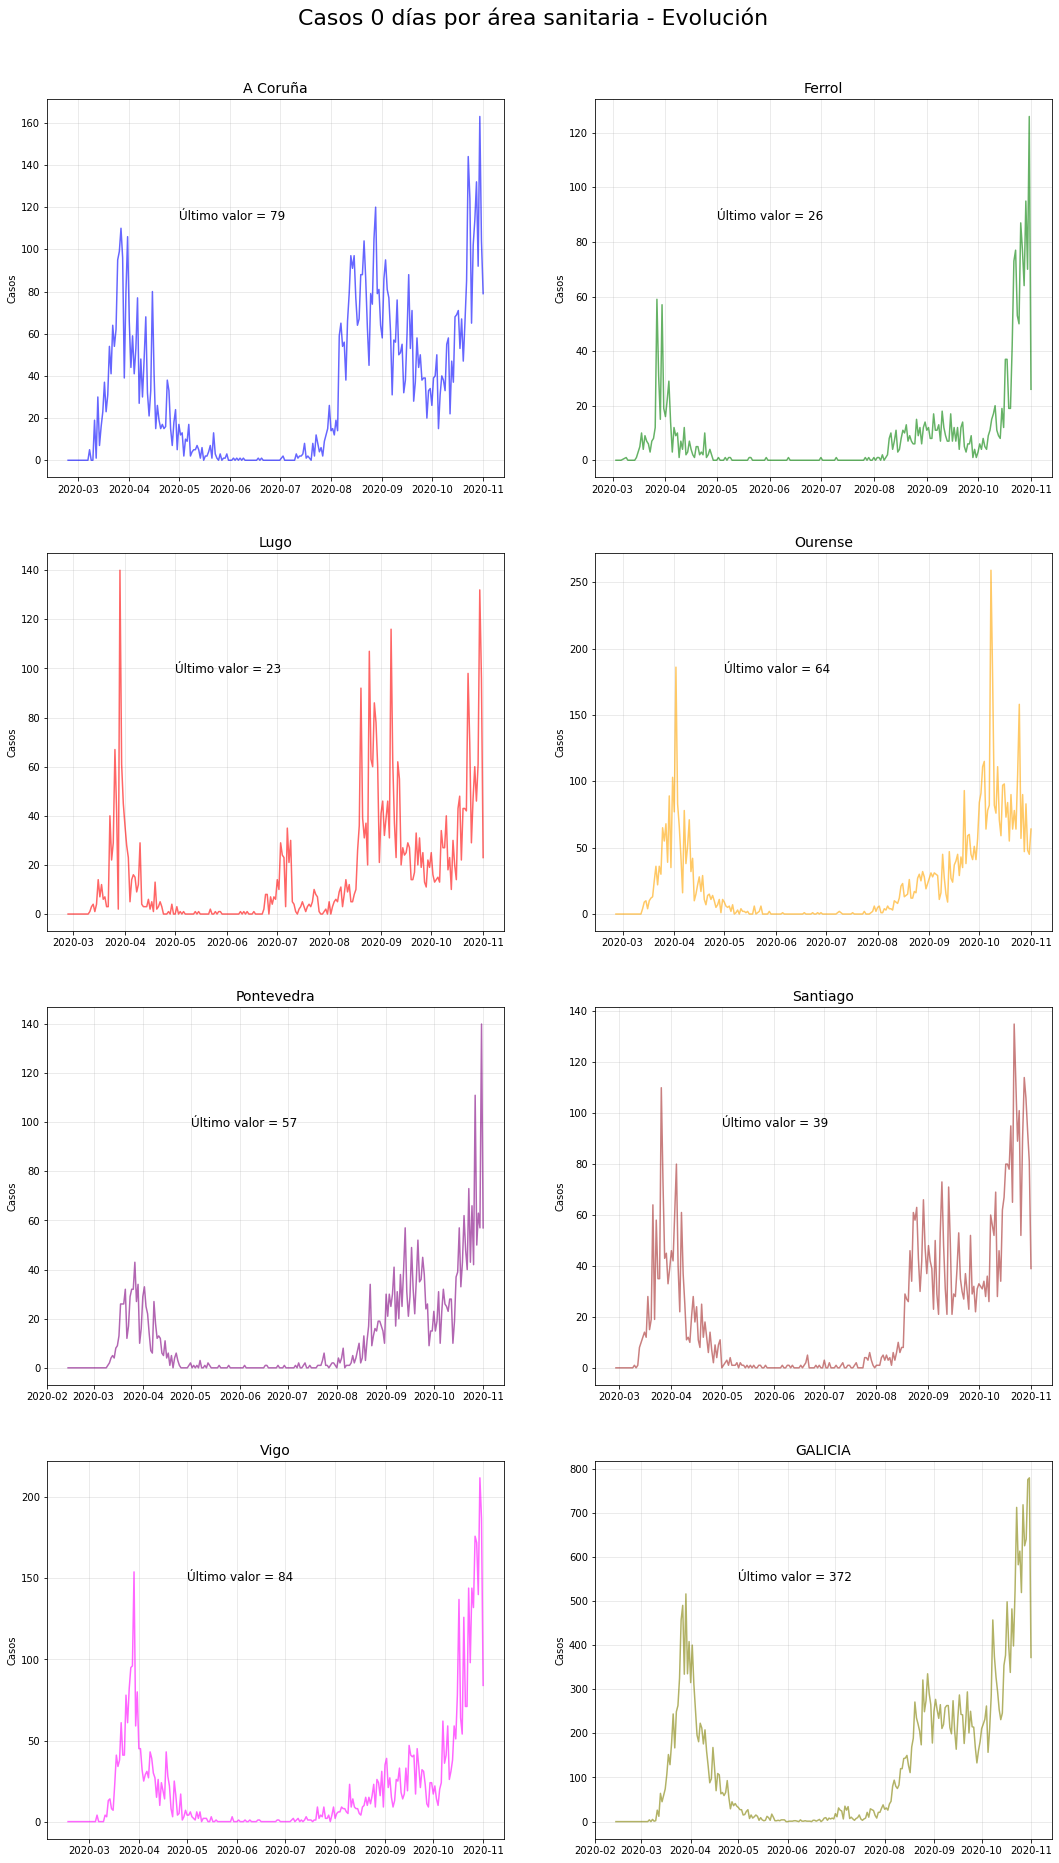

In [7]:
galicia.plotAcumulados(infectados_fecha, kind='Casos', days=0)

### 2.4.2. Evolución positivos acumulados últimos 7 días

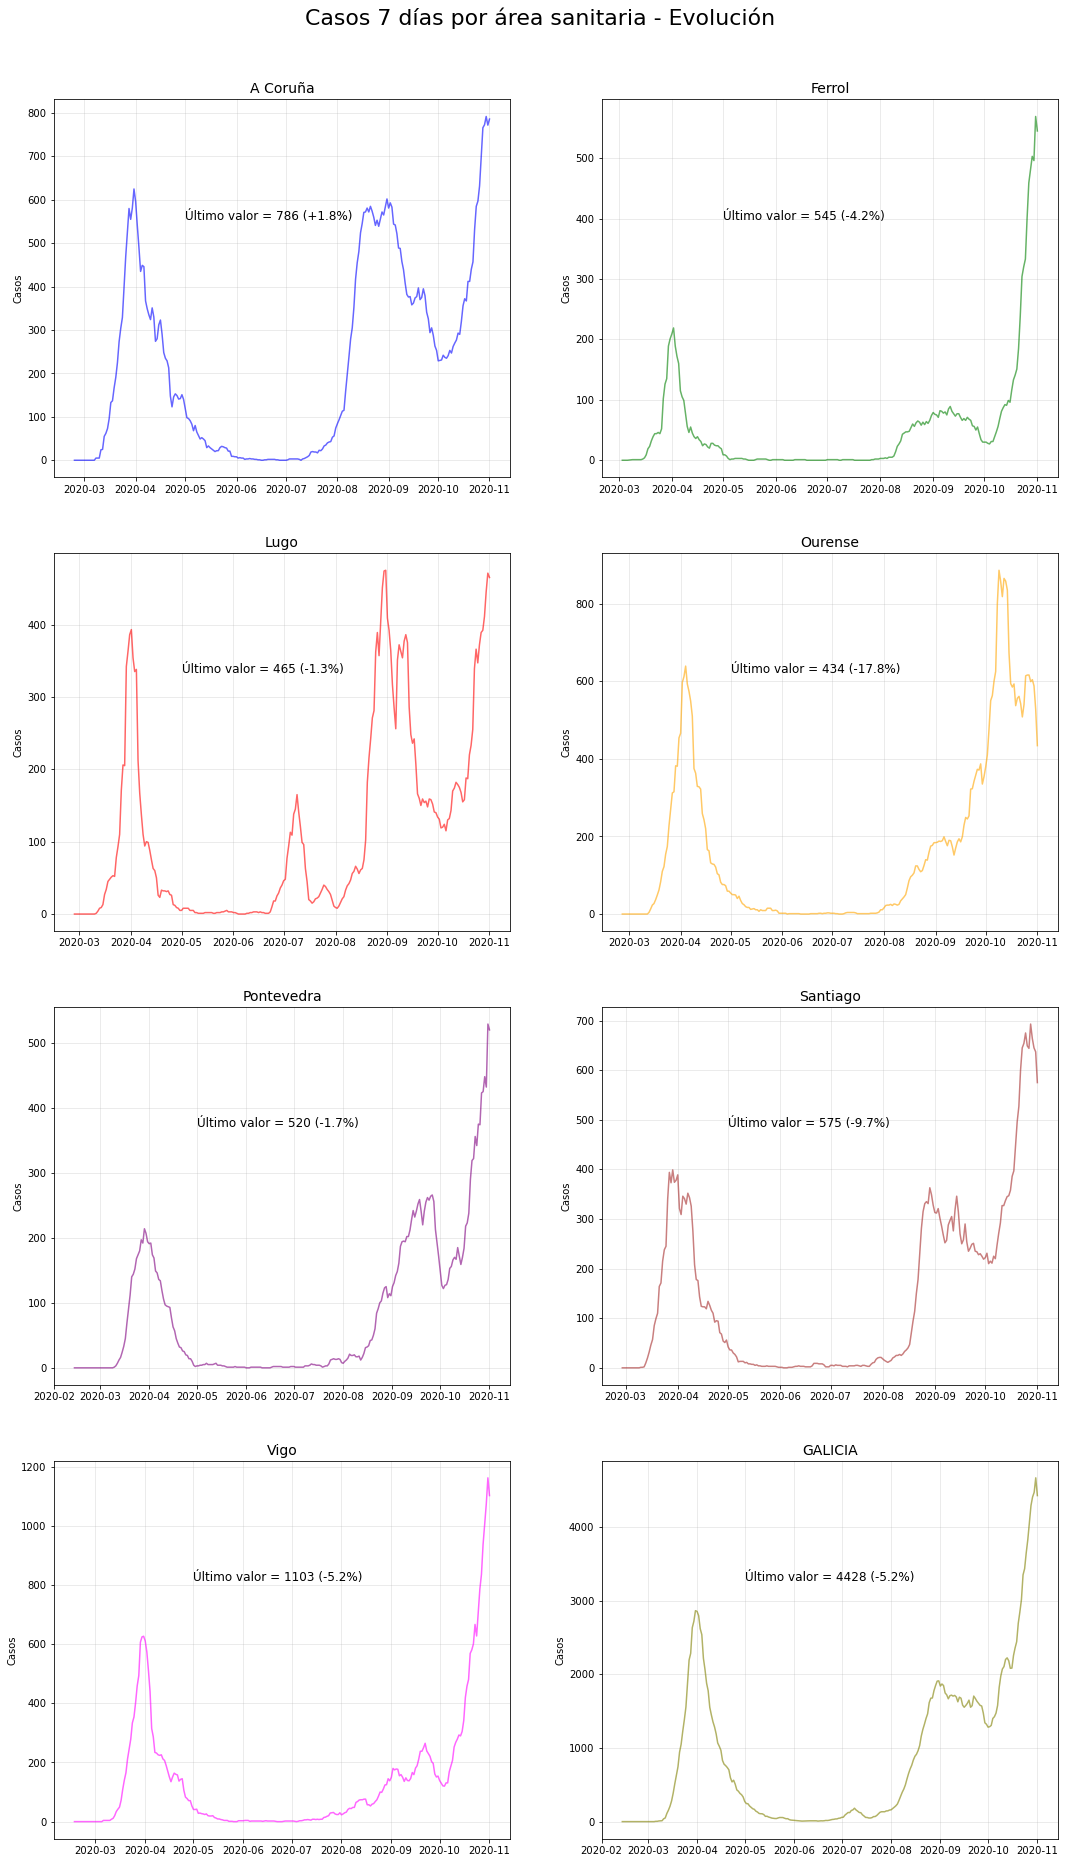

In [8]:
galicia.plotAcumulados(infectados_fecha, kind='Casos', days=7)

### 2.4.3. Evolución positivos acumulados últimos 14 días

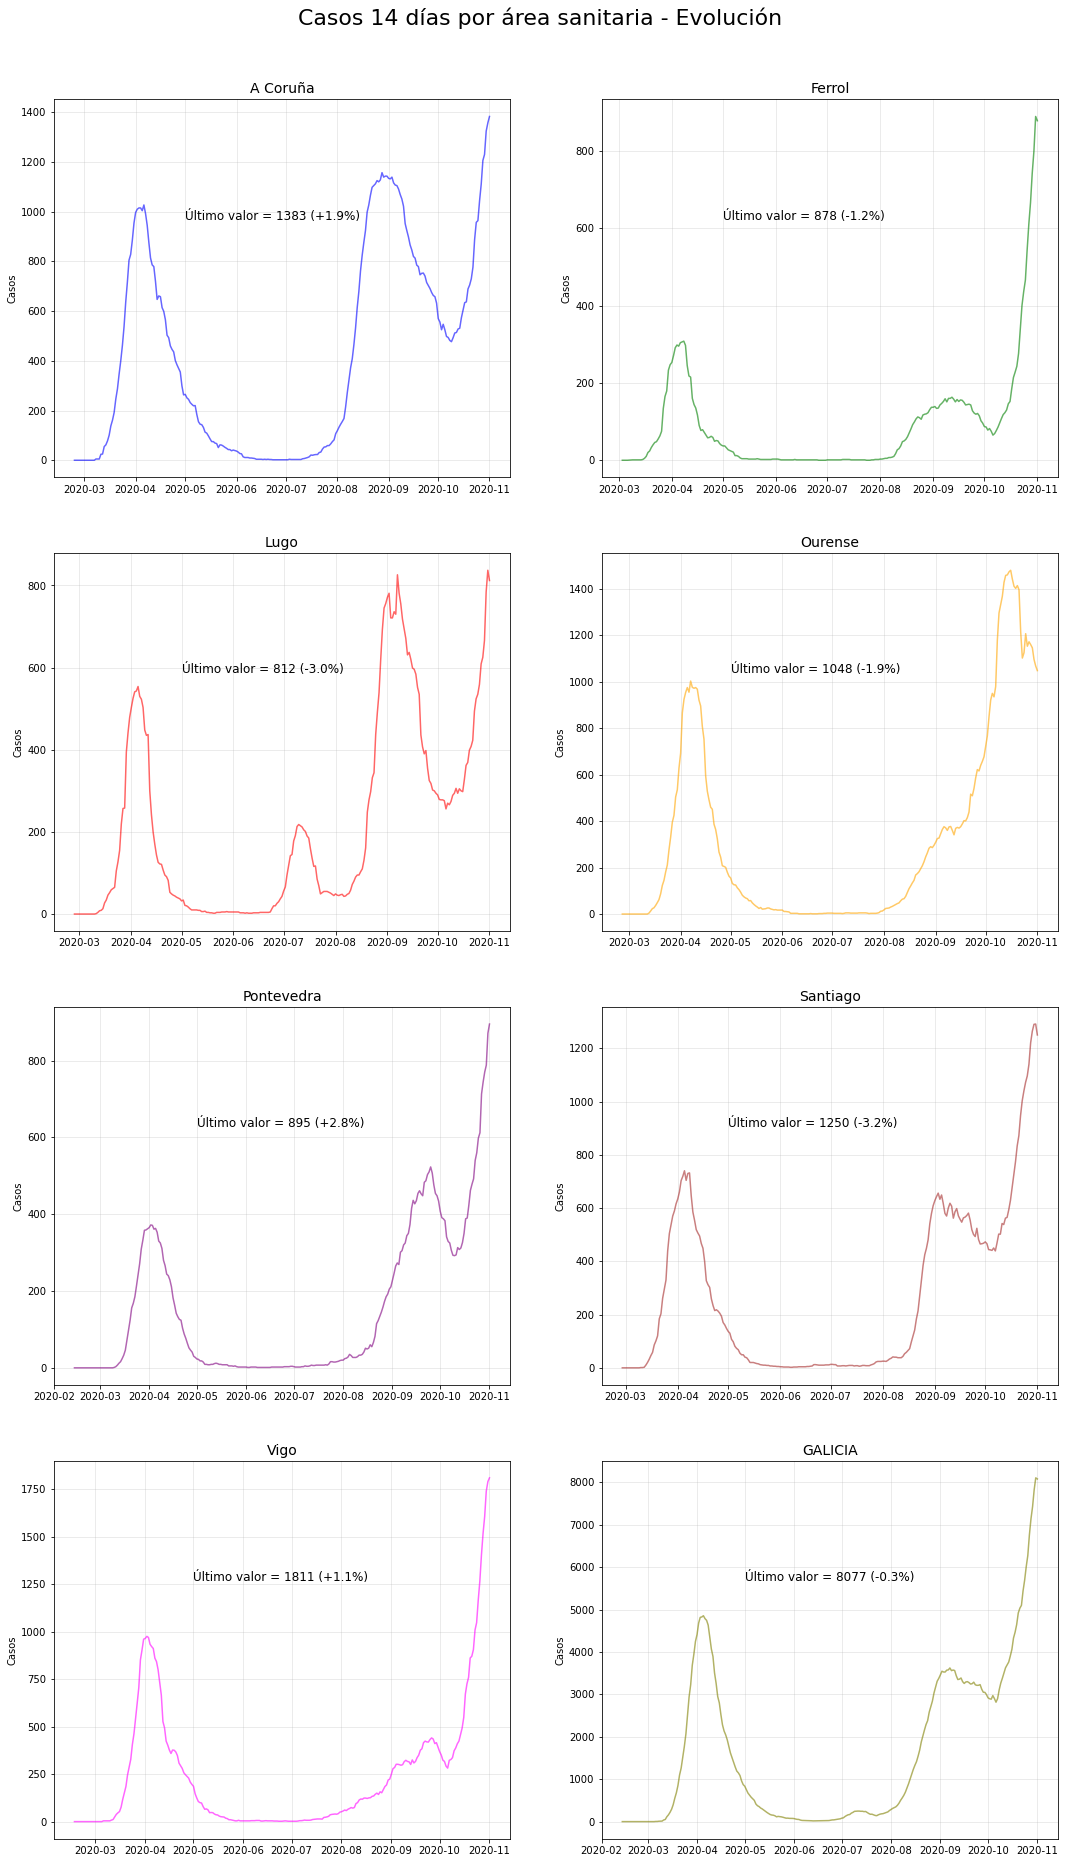

In [9]:
galicia.plotAcumulados(infectados_fecha, kind='Casos', days=14)

## 2.5. PCR

### 2.5.1. Evolución diaria de PCR positivas

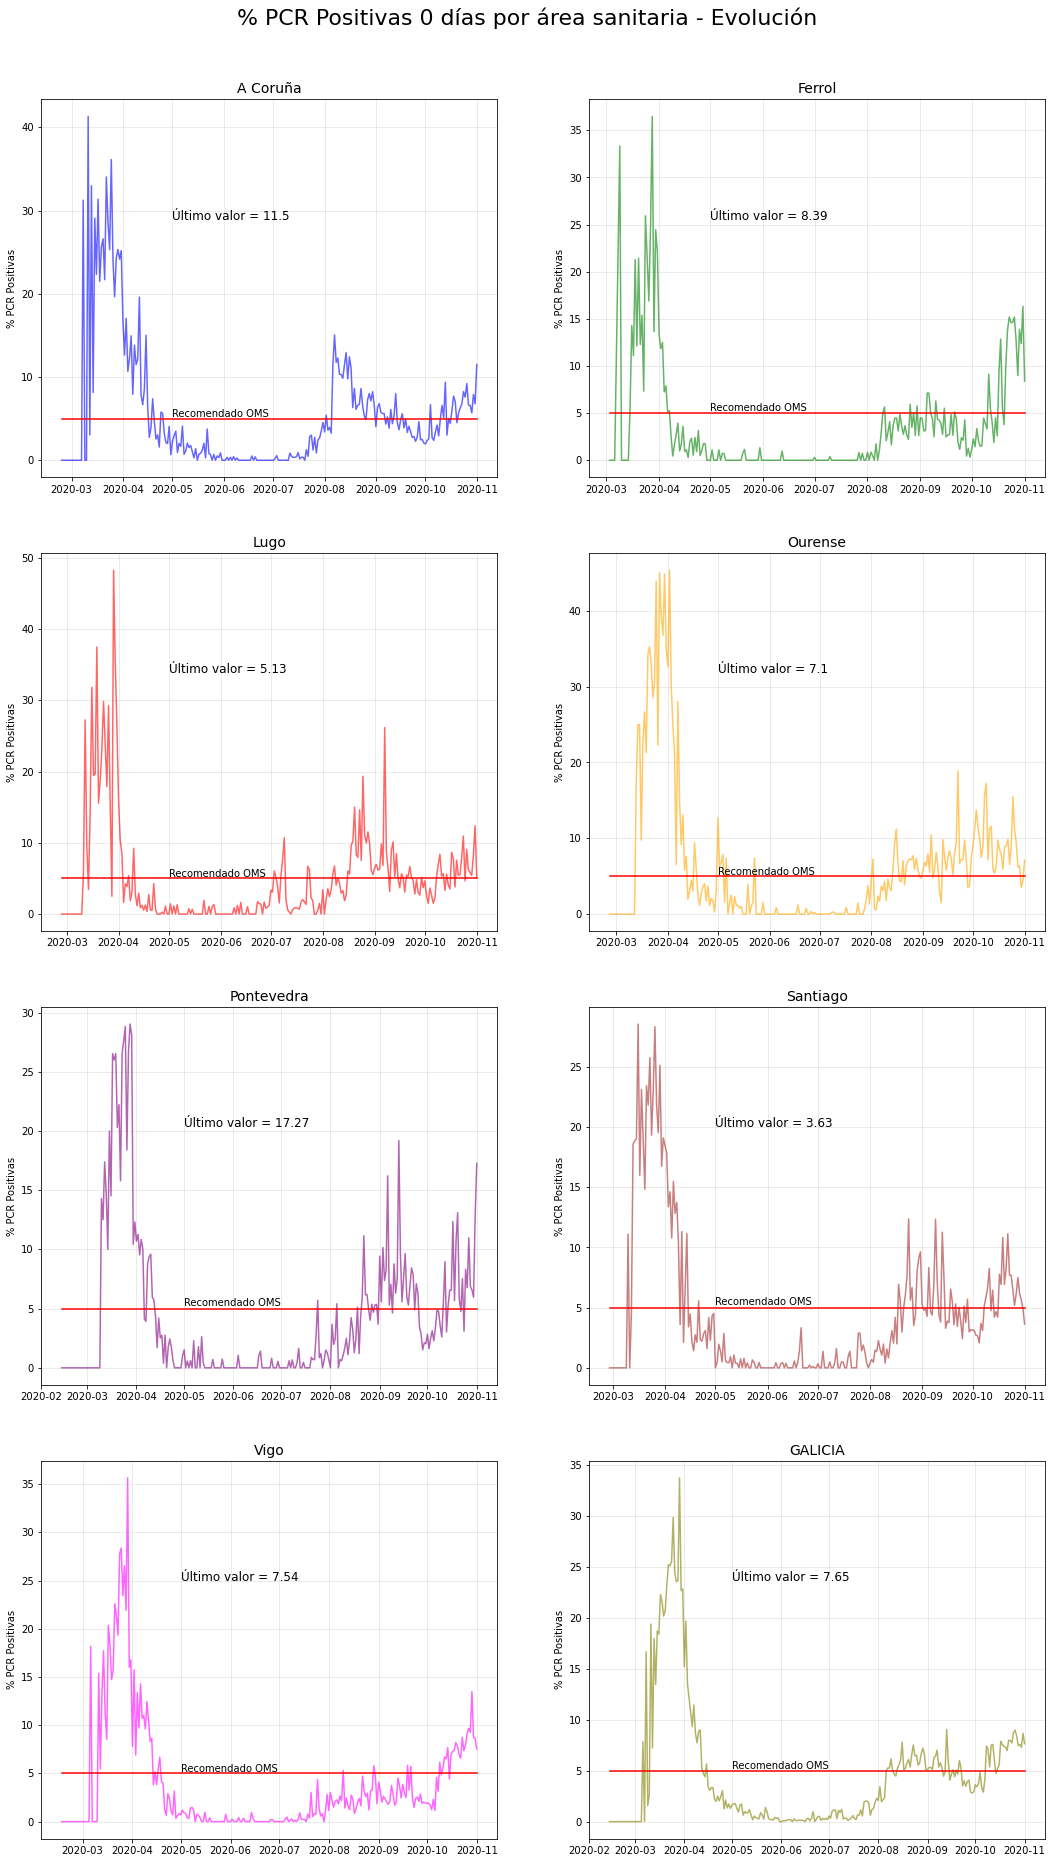

In [10]:
galicia.plotAcumulados(infectados_fecha, kind='PCR', days=0)

### 2.5.2. Evolución PCR positivas - 7 días

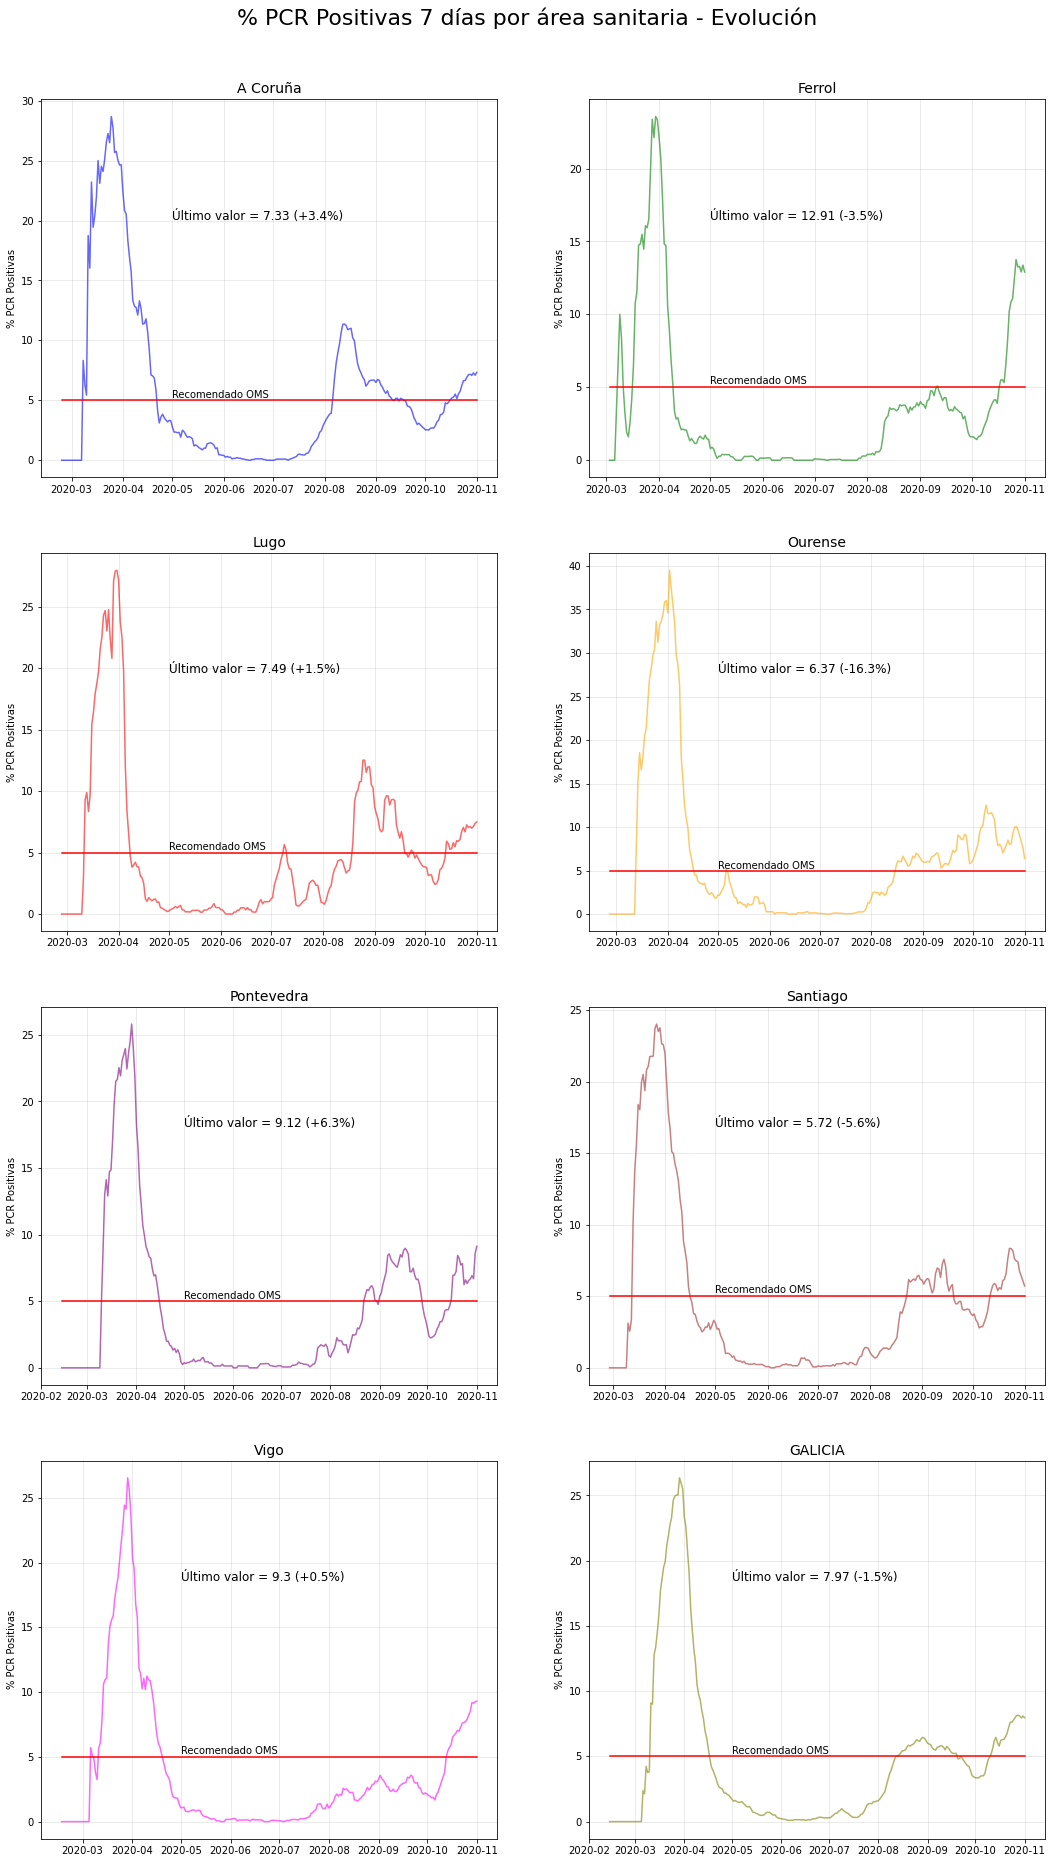

In [11]:
galicia.plotAcumulados(infectados_fecha, kind='PCR', days=7)

### 2.5.3. Evolución PCR positivas - 14 días

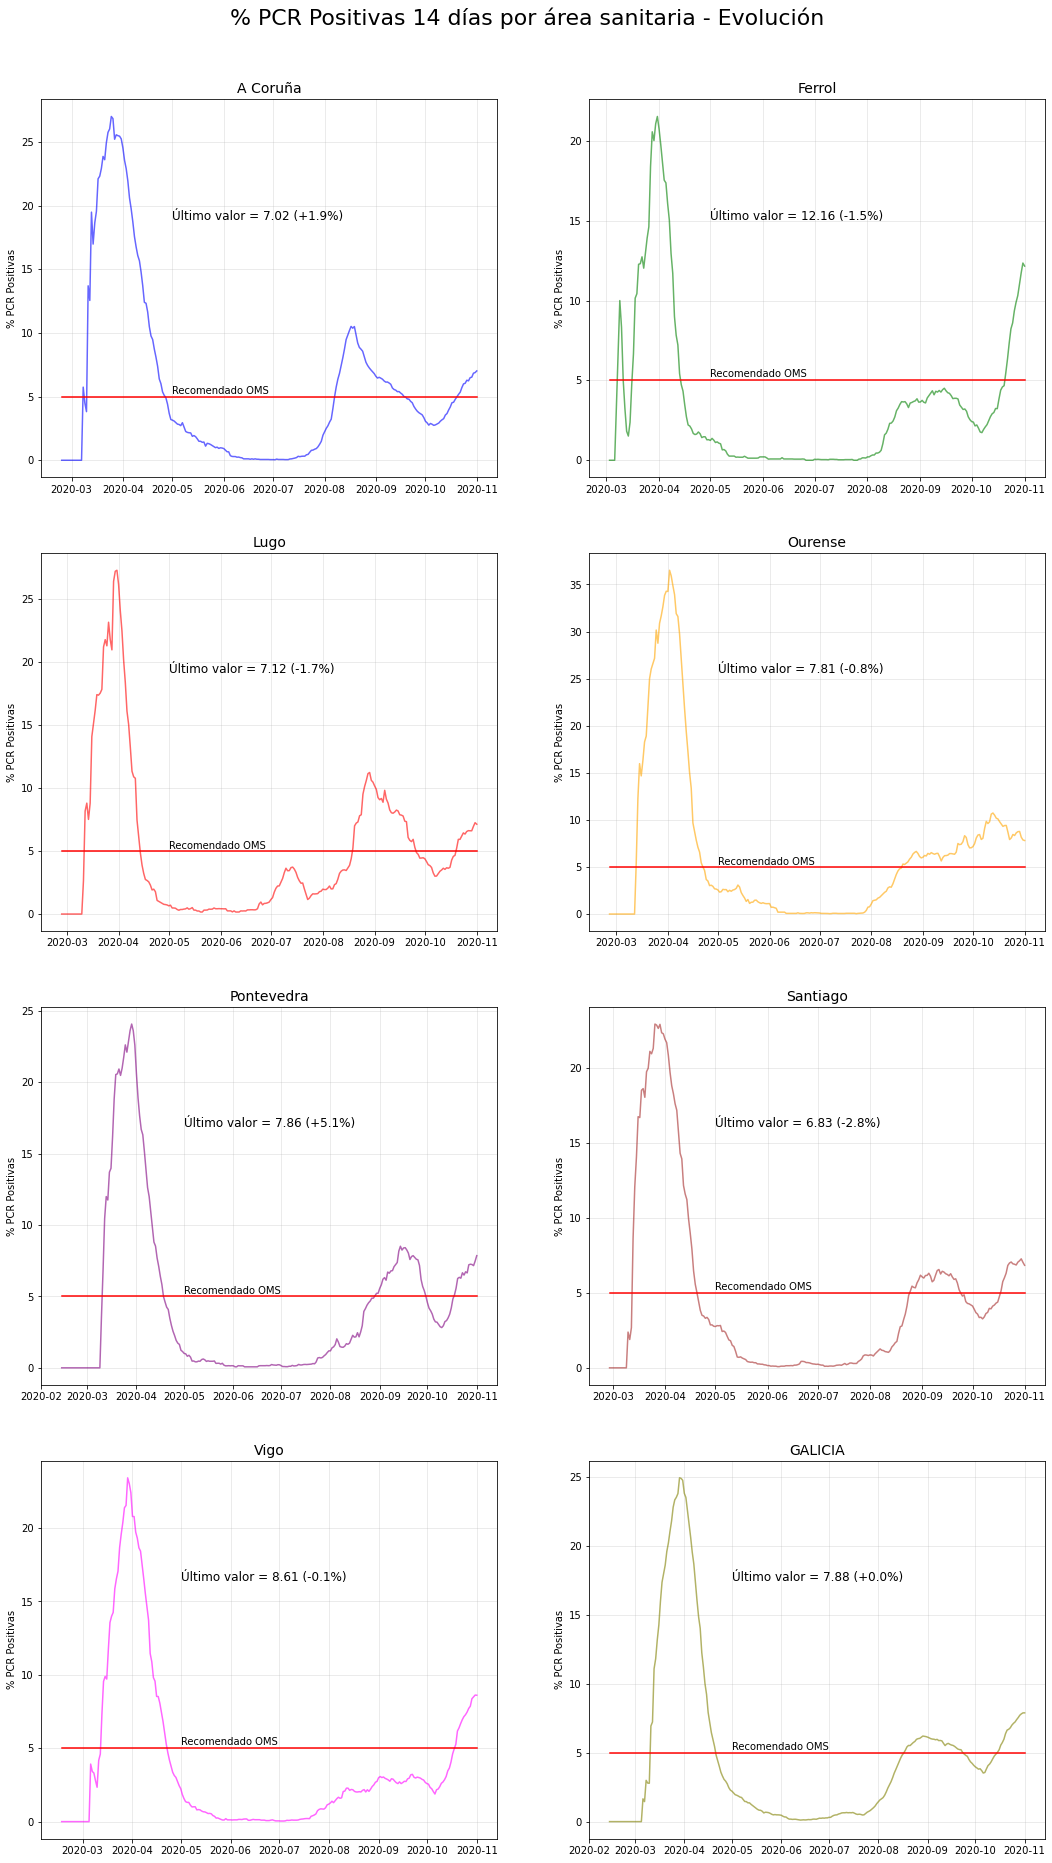

In [12]:
galicia.plotAcumulados(infectados_fecha, kind='PCR', days=14)

## 2.6. Ocupación actual de camas

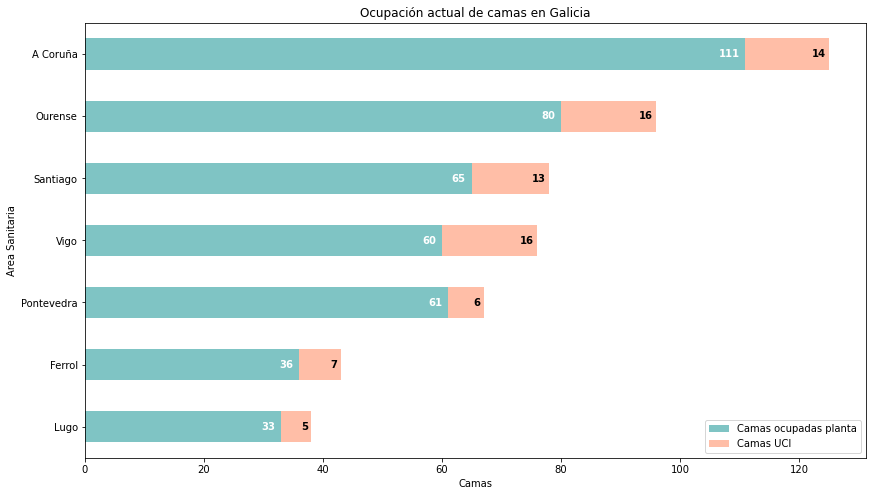

In [13]:
galicia.plotOcupacionCamas(camas)